In [1]:
import pandas as pd
import numpy as np
import json
import networkx as nx

In [9]:
try:
    input_args = json.loads(open('../input/simulation.json').read())
except Exception as ex:
    print('simulation.json does not exist!')
    print(ex)

In [10]:
# change the path for other waves of data - also adapt the bins of the histograms (the maximum values and ranges)
primary_school = '../data/Buzz_W5_primary-schools.csv'
secondary_school = '../data/Buzz_W5_secondary-schools.csv'

In [11]:
df_comm = pd.read_csv(primary_school, sep=';', header=0)
df_comm = df_comm.append(pd.read_csv(secondary_school, sep=';', header=0))
df_comm.shape

(174524, 30)

In [12]:
#surpress the scientific notation format that's shown by default
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [13]:
df_comm.Class.unique(),df_comm.Class.nunique()

(array([103.,  nan, 250., 251., 296., 297.,  82., 308., 135., 131., 133.,
        134., 100., 300., 301., 124., 298., 299., 303., 141., 125., 290.,
        291.,  73.,  74.,  81., 272., 273.,  78., 292.,  86., 261., 262.,
        263., 302., 279., 277., 256., 258., 259., 310., 304., 305., 306.,
        307.,  66.]),
 45)

###### comment out if you want to see only data from selected classes

In [14]:
df_comm = df_comm[df_comm.Class.isin(input_args["classes"])]
df_comm = df_comm[df_comm.Child.isin(input_args["participants"])]

In [15]:
df_comm.columns

Index(['Participant', 'School', 'Class', 'Child', 'Gender', 'Age', 'PI',
       'Date', 'Time', 'UMID', 'Format_text', 'Format_Media', 'Type',
       'RecipientChild', 'ClassReceive', 'Content', 'Media', 'ReactionInto',
       'Flagged', 'PostedWhileBanned', 'ShareSource', 'SharedVia',
       'Number_likes', 'Unnamed: 23', 'Unnamed: 24', 'Unnamed: 25',
       'Unnamed: 26', 'Unnamed: 27', 'Unnamed: 28', 'Unnamed: 29'],
      dtype='object')

In [16]:
df_comm.groupby(["Type"])['Type'].count()

Type
group      29731
my         26051
mymovez     1397
Name: Type, dtype: int64

In [17]:
df_comm_group = df_comm[df_comm.Type=="group"]
df_comm_group.shape

(29731, 30)

In [18]:
df_comm_ind = df_comm[df_comm.Type=="my"]
df_comm_ind.shape

(26051, 30)

In [19]:
df_comm.Participant.nunique(),df_comm.Child.nunique(),df_comm.RecipientChild.nunique()

(408, 408, 460)

In [20]:
df_comm = df_comm.astype({'Child': 'int32'})
df_comm = df_comm.astype({'Class': 'int32'})
df_comm = df_comm.astype({'Participant': 'float64'})



df_participants = df_comm.groupby(['Class','Participant','Child'])['UMID'].count().reset_index()
df_participants = df_participants[['Class','Participant','Child']]
df_participants['Participant'].nunique()

408

In [21]:
df_comm.Participant.dtype,df_comm.RecipientChild.dtype,

(dtype('float64'), dtype('float64'))

In [22]:
df_comm = df_comm.astype({'RecipientChild': 'string'})


df_comm['RecipientChild']

9502            <NA>
9503            <NA>
9504            <NA>
9505    5629600000.0
9506    5629600000.0
            ...     
7879    5425805075.0
7880    5425805075.0
7881    5425805075.0
7882    5425805075.0
7883    5425805075.0
Name: RecipientChild, Length: 57179, dtype: string

In [23]:
df_participants

,Class,Participant,Child
0,78,2807801633.00,1633
1,78,2807801636.00,1636
2,78,2807801637.00,1637
3,78,2807801639.00,1639
4,78,2807801640.00,1640
...,...,...,...
403,303,5830306085.00,6085
404,303,5830306086.00,6086
405,303,5830306088.00,6088
406,303,5830306089.00,6089


In [24]:
df_participants.dtypes

Class            int64
Participant    float64
Child            int64
dtype: object

In [25]:
df_participants

,Class,Participant,Child
0,78,2807801633.00,1633
1,78,2807801636.00,1636
2,78,2807801637.00,1637
3,78,2807801639.00,1639
4,78,2807801640.00,1640
...,...,...,...
403,303,5830306085.00,6085
404,303,5830306086.00,6086
405,303,5830306088.00,6088
406,303,5830306089.00,6089


In [27]:
df_participants['Participant'].dtype,df_comm['RecipientChild'].dtype

(dtype('float64'), StringDtype)

In [28]:
df_participants['Participant'].iloc[0] == df_comm['RecipientChild'].iloc[0]

<NA>

In [29]:
df_participants['Participant'].iloc[0]

2807801633.0

In [30]:
df_participants

,Class,Participant,Child
0,78,2807801633.00,1633
1,78,2807801636.00,1636
2,78,2807801637.00,1637
3,78,2807801639.00,1639
4,78,2807801640.00,1640
...,...,...,...
403,303,5830306085.00,6085
404,303,5830306086.00,6086
405,303,5830306088.00,6088
406,303,5830306089.00,6089


In [31]:
df_comm['AlterChild'] = df_participants.loc[df_participants['Participant'] == df_comm['RecipientChild'].iloc[0], 'Child']

### Messages exchanged between individuals

##### draft: making the connection weights

In [32]:
# messages per class 
df_comm.groupby('Class')['UMID'].count()

Class
78      492
81      434
100    1789
124     755
125    1201
256     483
258     250
261    1652
262    1821
263    3484
272    5121
273    2474
292    5348
296    2712
297    1163
298    8572
299    5973
300    1201
301    5476
302    1828
303    4950
Name: UMID, dtype: int64

In [33]:
df_test = df_comm[df_comm.Class.isin([81])]
df_test

,Participant,School,Class,Child,Gender,Age,PI,Date,Time,UMID,...,SharedVia,Number_likes,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,AlterChild
101905,2908101605.00,29.00,81,1605,1.00,14.00,0.00,6-3-2018,14:56,85433,...,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
101906,2908101605.00,29.00,81,1605,1.00,14.00,0.00,6-3-2018,14:57,85447,...,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
101907,2908101605.00,29.00,81,1605,1.00,14.00,0.00,6-3-2018,15:12,85701,...,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
101908,2908101605.00,29.00,81,1605,1.00,14.00,0.00,6-3-2018,15:12,85709,...,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
101909,2908101605.00,29.00,81,1605,1.00,14.00,0.00,6-3-2018,15:12,85711,...,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102351,2908101632.00,29.00,81,1632,0.00,11.00,0.00,6-3-2018,14:50,85355,...,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
102352,2908101632.00,29.00,81,1632,0.00,11.00,0.00,6-3-2018,14:50,85358,...,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
102353,2908101632.00,29.00,81,1632,0.00,11.00,0.00,8-3-2018,7:39,94699,...,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
102354,2908101632.00,29.00,81,1632,0.00,11.00,0.00,8-3-2018,7:39,94703,...,NaN,1.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
df_test.Participant.unique()

array([2.90810160e+09, 2.90810161e+09, 2.90810161e+09, 2.90810161e+09,
       2.90810161e+09, 2.90810161e+09, 2.90810161e+09, 2.90810161e+09,
       2.90810161e+09, 2.90810162e+09, 2.90810162e+09, 2.90810162e+09,
       2.90810162e+09, 2.90810162e+09, 2.90810163e+09, 2.90810163e+09,
       2.90810163e+09, 2.90810163e+09, 2.90810163e+09])

In [35]:
#this is actually the number of edges
df_pairs = df_test.groupby(["Participant","RecipientChild"])["UMID"].count().reset_index(name='NumberMessages')
df_pairs

,Participant,RecipientChild,NumberMessages
0,2908101605.00,2908100000.0,4
1,2908101605.00,2908101620.0,1
2,2908101605.00,2908101631.0,4
3,2908101606.00,2908100000.0,4
4,2908101606.00,2908101617.0,2
...,...,...,...
90,2908101631.00,2908101609.0,1
91,2908101631.00,2908101617.0,8
92,2908101631.00,2908101623.0,2
93,2908101631.00,2908101625.0,2


In [36]:
df_pairs = df_pairs.astype({'NumberMessages': 'float64'})
df_pairs = df_pairs.astype({'Participant': 'float64'})

In [37]:
df_pairs.dtypes

Participant       float64
RecipientChild     object
NumberMessages    float64
dtype: object

In [38]:
df_pairs['Weight'] = df_pairs['NumberMessages']/max(df_pairs['NumberMessages'])
df_pairs

,Participant,RecipientChild,NumberMessages,Weight
0,2908101605.00,2908100000.0,4.00,0.50
1,2908101605.00,2908101620.0,1.00,0.12
2,2908101605.00,2908101631.0,4.00,0.50
3,2908101606.00,2908100000.0,4.00,0.50
4,2908101606.00,2908101617.0,2.00,0.25
...,...,...,...,...
90,2908101631.00,2908101609.0,1.00,0.12
91,2908101631.00,2908101617.0,8.00,1.00
92,2908101631.00,2908101623.0,2.00,0.25
93,2908101631.00,2908101625.0,2.00,0.25


In [39]:
df_pairs.RecipientChild.nunique()

28

In [40]:
graph = nx.DiGraph()
for index, row in df_pairs.iterrows():
    graph.add_edge(row[0],row[1],weight=row[3])

In [41]:
graph.nodes(),len(graph.nodes())

(NodeView((2908101605.0, '2908100000.0', '2908101620.0', '2908101631.0', 2908101606.0, '2908101617.0', 2908101607.0, '2908101615.0', '2908101630.0', 2908101608.0, '2908101610.0', '2908101611.0', '2908101614.0', '2908101616.0', '2908101621.0', '2908101623.0', '2908101625.0', '2908101626.0', '2908101627.0', '2908101628.0', '2908101632.0', 2908101609.0, 2908101610.0, '2908101612.0', 2908101611.0, 2908101612.0, 2908101614.0, 2908101615.0, '2908101607.0', 2908101617.0, '2908101606.0', '2908101608.0', 2908101620.0, '2908101605.0', '2908101609.0', '2908101613.0', '2908101619.0', '2908101622.0', '2908101629.0', '2908104362.0', 2908101623.0, 2908101625.0, 2908101626.0, 2908101627.0, 2908101630.0, 2908101631.0, 2908101632.0)),
 47)

In [42]:
len(graph.edges)

95

In [43]:
df_comm_ind['Class'].nunique(),df_comm_ind['Child'].nunique(),df_comm_ind['RecipientChild'].nunique()

(21, 408, 439)

In [44]:
df_comm_ind.groupby(["Class"])["Child"].nunique()

Class
78.00     18
81.00     19
100.00    19
124.00    17
125.00    16
256.00    22
258.00    16
261.00    17
262.00    15
263.00    20
272.00    24
273.00    24
292.00    21
296.00    17
297.00    16
298.00    21
299.00    19
300.00    19
301.00    24
302.00    19
303.00    25
Name: Child, dtype: int64

In [45]:
df_messages_per_child = df_comm_ind.groupby("Child")["UMID"].count().reset_index()
df_messages_per_child

,Child,UMID
0,1605.00,5
1,1606.00,2
2,1607.00,10
3,1608.00,16
4,1609.00,1
...,...,...
403,6085.00,14
404,6086.00,13
405,6088.00,105
406,6089.00,24


In [46]:
df_messages_per_child['UMID'].describe()

count   408.00
mean     63.85
std     103.97
min       1.00
25%       9.00
50%      23.50
75%      69.50
max     789.00
Name: UMID, dtype: float64

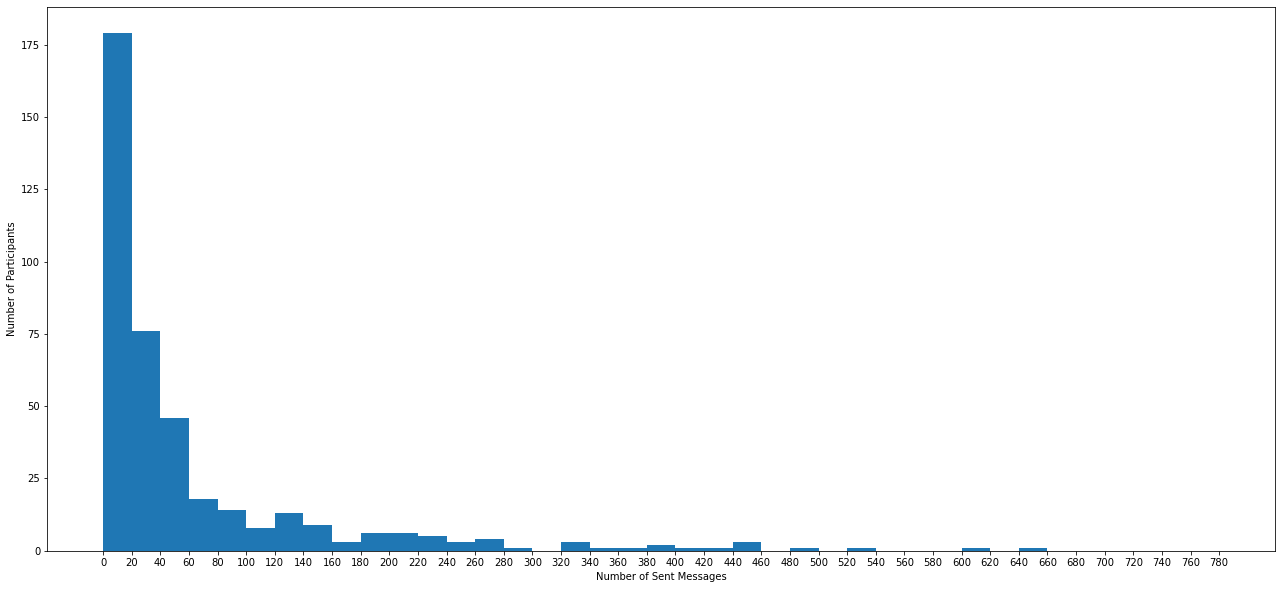

In [47]:
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(22, 10)
bins = range(0,790,20)
plt.xticks(bins)
df_comm_ind.groupby("Participant")["UMID"].count().plot.hist(bins=bins)
ax.set_xlabel('Number of Sent Messages')
ax.set_ylabel('Number of Participants')
plt.show()

In [48]:
pairs_freq = df_comm_ind.groupby(["Participant","RecipientChild"])["UMID"].count().reset_index(name='NumberMessages')
pairs_freq

,Participant,RecipientChild,NumberMessages
0,2807801633,2807801641.00,1
1,2807801633,2807801644.00,2
2,2807801633,2807801645.00,3
3,2807801633,2807801649.00,1
4,2807801633,2807801655.00,3
...,...,...,...
3230,5830306089,5830306088.00,11
3231,5830306090,5830306063.00,3
3232,5830306090,5830306068.00,2
3233,5830306090,5830306077.00,3


In [49]:
pairs_freq = pairs_freq.astype({'Participant': 'float64'})

In [50]:
pairs = []
values = []
exchanged_messages = []
for line in pairs_freq[["Participant","RecipientChild", "NumberMessages"]].iterrows():
    (p1, p2, var) = line[1]
    if(p1, p2) not in pairs and (p2, p1) not in pairs:
        pairs.append((p1,p2))
        values.append((var))

    elif (p2, p1) in pairs:
        # get the index of this pair and update in the values of the same index
        ind = pairs.index((p2,p1))
        values[ind] = (values[ind] + var)

# print('found pairs',pairs)
# print('found values',values)


count = 0
for line in pairs:
    (pp1, pp2) = line
    exchanged_messages.append((pp1,pp2,values[count]))
    count = count + 1

exchanged_messages = pd.DataFrame(exchanged_messages, columns = ["P1", "P2", "NumMes"])
exchanged_messages

,P1,P2,NumMes
0,2807801633.00,2807801641.00,1.00
1,2807801633.00,2807801644.00,2.00
2,2807801633.00,2807801645.00,7.00
3,2807801633.00,2807801649.00,1.00
4,2807801633.00,2807801655.00,3.00
...,...,...,...
1968,5830306086.00,5830306062.00,4.00
1969,5830306086.00,5830306079.00,1.00
1970,5830306088.00,5830306060.00,2.00
1971,5830306088.00,5830306089.00,23.00


In [51]:
exchanged_messages["NumMes"].describe()

count   1973.00
mean      13.20
std       38.21
min        1.00
25%        2.00
50%        4.00
75%       10.00
max      637.00
Name: NumMes, dtype: float64

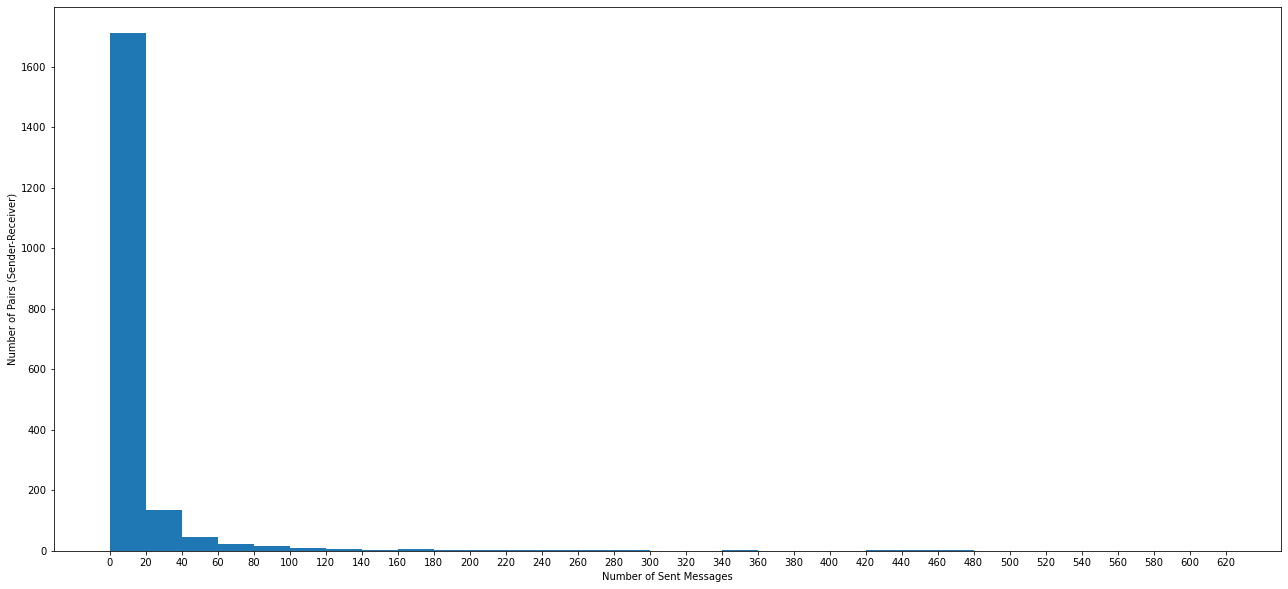

In [52]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(22, 10)
bins = range(0,640,20)
plt.xticks(bins)
exchanged_messages["NumMes"].plot.hist(bins=bins)
ax.set_xlabel('Number of Sent Messages')
ax.set_ylabel('Number of Pairs (Sender-Receiver)')
plt.show()

In [53]:
df_ind_images = df_comm_ind.groupby(["Participant","Format_Media"])["UMID"].count().reset_index(name = "NumberImages")
df_ind_images.head()

,Participant,Format_Media,NumberImages
0,2807801633,image,1
1,2807801633,video,5
2,2807801636,video,1
3,2807801637,image,2
4,2807801637,video,1


In [54]:
df_ind_images['NumberImages'].describe()

count   426.00
mean      5.84
std      10.07
min       1.00
25%       1.00
50%       2.00
75%       6.00
max     120.00
Name: NumberImages, dtype: float64

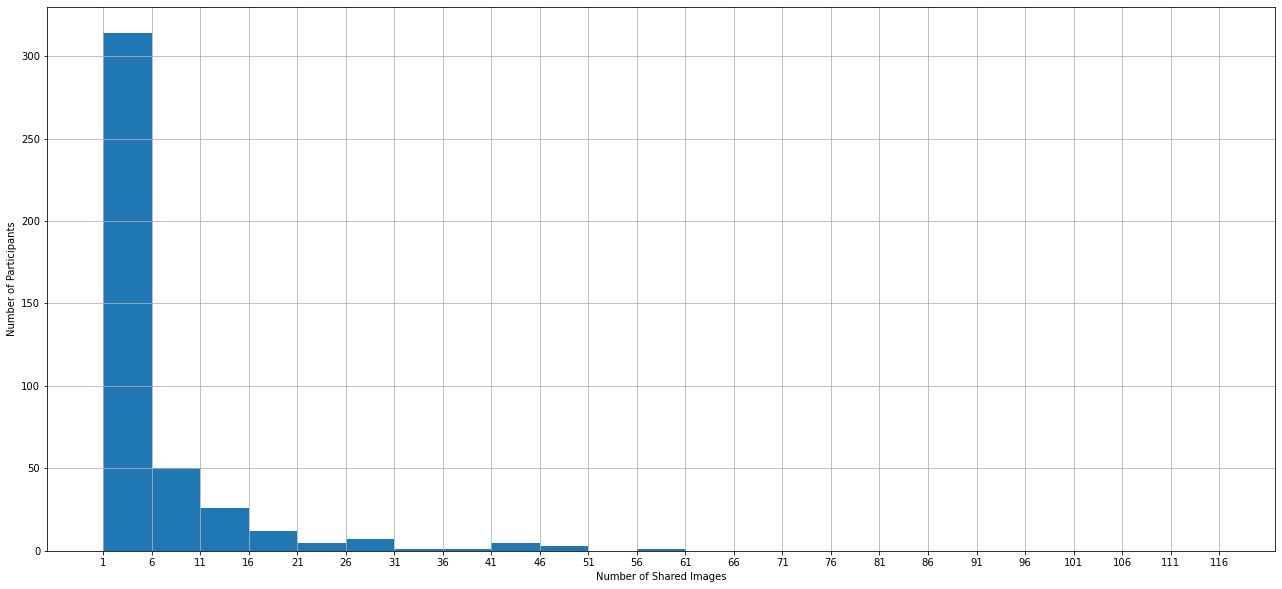

In [55]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(22, 10)
bins = range(1,120,5)
plt.xticks(bins)
df_ind_images['NumberImages'].hist(bins=bins)
ax.set_xlabel('Number of Shared Images')
ax.set_ylabel('Number of Participants')
plt.show()

In [56]:
df_comm_ind['Date'].unique()

array(['27-2-2018', '28-2-2018', '1-3-2018', '2-3-2018', '4-3-2018',
       '3-3-2018', '5-3-2018', '7-3-2018', '8-3-2018', '9-3-2018',
       '11-3-2018', '13-3-2018', '10-3-2018', '12-3-2018', '6-3-2018',
       '14-3-2018', '15-3-2018', '16-3-2018', '17-3-2018', '18-3-2018',
       '20-3-2018', '19-3-2018', '15-2-2018', '16-2-2018', '17-2-2018',
       '18-2-2018', '20-2-2018', '19-2-2018', '21-2-2018'], dtype=object)

In [57]:
df_comm_ind.groupby(['Date'])['UMID'].count().reset_index()

,Date,UMID
0,1-3-2018,1552
1,10-3-2018,565
2,11-3-2018,281
3,12-3-2018,251
4,13-3-2018,719
5,14-3-2018,559
6,15-2-2018,1241
7,15-3-2018,549
8,16-2-2018,1185
9,16-3-2018,618


### Group messages

In [58]:
df_comm_ind.groupby(["Class"])["Participant"].nunique()

Class
78.00     18
81.00     19
100.00    19
124.00    17
125.00    16
256.00    22
258.00    16
261.00    17
262.00    15
263.00    20
272.00    24
273.00    24
292.00    21
296.00    17
297.00    16
298.00    21
299.00    19
300.00    19
301.00    24
302.00    19
303.00    25
Name: Participant, dtype: int64

In [59]:
df_group_messages_per_child = df_comm_group.groupby("Child")["UMID"].count().reset_index()
df_group_messages_per_child.head()

,Child,UMID
0,1605.00,14
1,1606.00,3
2,1607.00,27
3,1608.00,2
4,1609.00,3


In [60]:
df_group_messages_per_child['UMID'].describe()

count   401.00
mean     74.14
std      90.68
min       1.00
25%      12.00
50%      36.00
75%     110.00
max     539.00
Name: UMID, dtype: float64

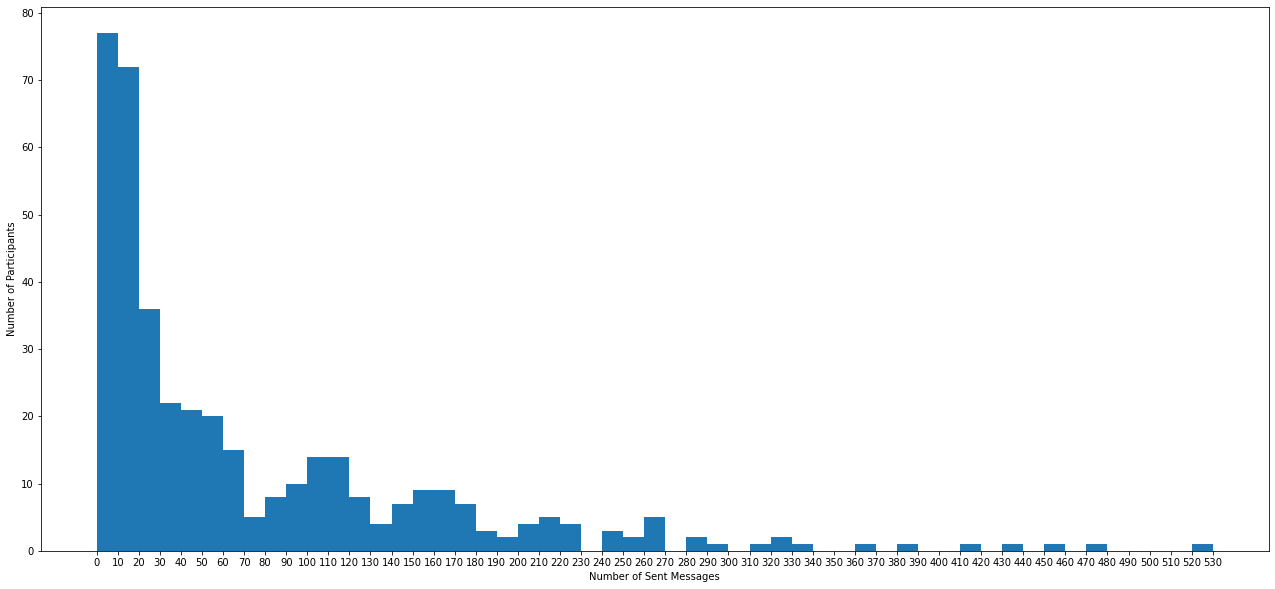

In [61]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(22, 10)
bins = range(0,540,10)
plt.xticks(bins)
df_group_messages_per_child['UMID'].plot.hist(bins=bins)
ax.set_xlabel('Number of Sent Messages')
ax.set_ylabel('Number of Participants')
plt.show()

In [62]:
df_comm_group = df_comm_group.astype({'Number_likes': 'int32'})

In [63]:
df_child_like = df_comm_group.groupby(['Child'])['Number_likes'].sum().reset_index()

In [64]:
df_child_like['Number_likes'].describe()

count   401.00
mean     12.44
std      16.19
min       0.00
25%       2.00
50%       8.00
75%      17.00
max     156.00
Name: Number_likes, dtype: float64

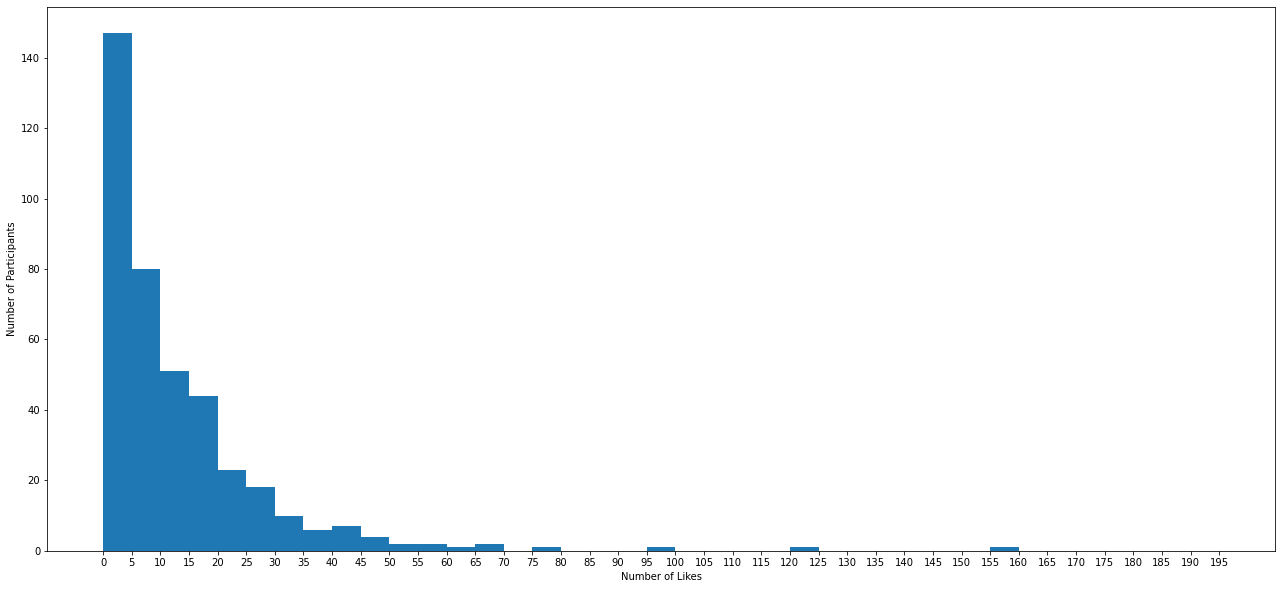

In [65]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(22, 10)
bins = range(0,200,5)
plt.xticks(bins)
df_child_like['Number_likes'].plot.hist(bins=bins)
ax.set_xlabel('Number of Likes')
ax.set_ylabel('Number of Participants')
plt.show()

In [66]:
# images exhanged in group vs peer-to-peer communication
df_comm_group['Format_Media'].count(),df_comm_ind['Format_Media'].count()

(3501, 2487)

In [67]:
df_group_images = df_comm_group.groupby(["Participant","Format_Media"])["UMID"].count().reset_index(name = "NumberImages")
df_group_images.head()

,Participant,Format_Media,NumberImages
0,2807801633,image,2
1,2807801636,image,1
2,2807801636,video,1
3,2807801637,image,1
4,2807801639,image,1


In [68]:
df_group_images['NumberImages'].describe()

count   556.00
mean      6.30
std       8.99
min       1.00
25%       2.00
50%       4.00
75%       7.00
max     126.00
Name: NumberImages, dtype: float64

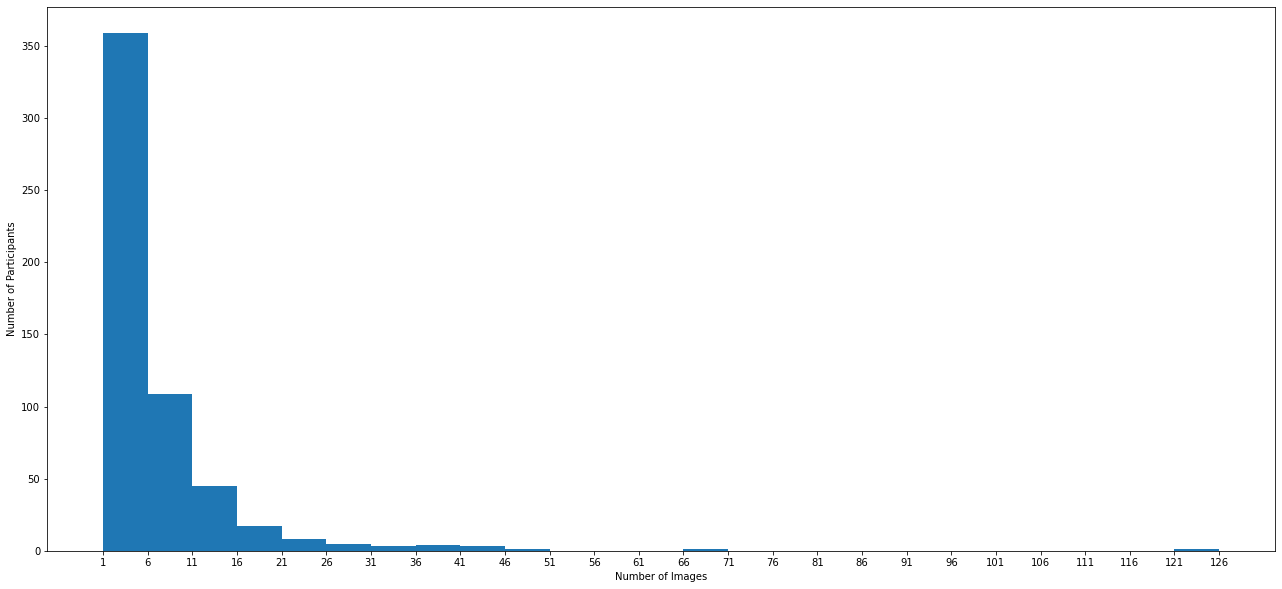

In [69]:

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(22, 10)
bins = range(1,130,5)
plt.xticks(bins)
df_group_images['NumberImages'].plot.hist(bins=bins)
ax.set_xlabel('Number of Images')
ax.set_ylabel('Number of Participants')
plt.show()